# RQ2 Analysis
This notebook contains the analysis for RQ2. The goal of this analysis is to understand the evolution of the serialization format used in the dataset over the years.

## Select the dataset to analyze

In [19]:
group_under_analysis = 'recent'  # change this to 'legacy' or 'recent' to analyze the corresponding dataset

## Load the data
The data is loaded from the `read_repositories_evolution` function, which reads the evolution of repositories from a CSV file. The data contains the commit hash, date, repository URL, and serialization format for each model file in the tree at the time.

In [20]:
from scripts.notebooks.nb_utils import read_repositories_evolution

# model files per repository and the elapsed days between the commit and safetensors' release date
df = read_repositories_evolution(group_under_analysis)
df['year'] = df['date'].dt.year
df['year'] = df['year'].astype(int)  # set year as an integer
df['month'] = df['date'].dt.to_period('M')
year_range = list(range(df['year'].min(), df['year'].max() + 1))
df.head(5)


100%|██████████| 527512/527512 [00:06<00:00, 81992.38commit/s]


,repo_url,commit_hash,model_file_path,serialization_format,message,author,date,is_in_commit,elapsed_days,change_status,year,month
0,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/<v1*>.bin,torch.save,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
1,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/pytorch_cust...,torch.save,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
2,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/checkpoint-2...,torch.save,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
3,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/checkpoint-2...,safetensors,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10
4,SidXXD/Pattern_d_0.60_Man_1_Eps_8,9b2be96bb789b1aff091e8ba8e41a5fbeb2705c1,SidXXD/Pattern_d_0.60_Man_1_Eps_8/checkpoint-2...,safetensors,End of training,XideXu,2024-10-23 05:14:58,True,762,*,2024,2024-10


## Prepare the data
For each repository, we want to find the last commit hash per year. If a repository does not have a commit hash for a specific year, we will use the last commit hash from the previous year(s).

In [21]:
import pandas as pd
# find the last commit hash per repository per year
df_last_hash = df.sort_values('date').drop_duplicates(['repo_url', 'year'], keep='last')
df_last_hash = df_last_hash[['repo_url', 'year', 'commit_hash', 'date']]

# ensure that all repos have one hash a year, if not, use last years'  hash
last_hash_per_repo = { (r['repo_url'], r['year']): r for _, r in df_last_hash.iterrows() }
for repo_url in df['repo_url'].unique():
    for year in year_range:
        key = (repo_url, year)
        if key not in last_hash_per_repo:
            # find the last commit hash from the previous year(s)
            for y in range(year, df['year'].min() - 1, -1):
                if (repo_url, y) in last_hash_per_repo:
                    df_last_hash = pd.concat([df_last_hash, pd.DataFrame({
                        'repo_url': [repo_url],
                        'year': [year],
                        'commit_hash': [last_hash_per_repo[(repo_url, y)]['commit_hash']],
                        'date': [last_hash_per_repo[(repo_url, y)]['date']]
                    })], ignore_index=True)
                    break

# df_last_hash[df_last_hash['repo_url'] == 'google-bert/bert-base-chinese']
df_last_hash

,repo_url,year,commit_hash,date
0,speechbrain/ssl-wav2vec2-base-librispeech,2022,c89c07f66cef94b4a7b9f4a11444bcca5e84da34,2022-09-22 04:42:25
1,opennyaiorg/en_legal_ner_trf,2022,ef1c7f0622531961e39b7e121fea045fb3ef8451,2022-09-22 05:54:44
2,opennyaiorg/en_legal_ner_sm,2022,2acec6cc86b51e75d344f33198625d3f7b6ec53c,2022-09-22 07:48:18
3,Intel/t5-small-xsum-int8-dynamic-inc,2022,0a9ad763bf229beb12580ce2c50f498d33b48f0a,2022-09-22 08:39:43
4,suresh-subramanian/beans-classification,2022,1430fcd2a2ff4534acede1f114ff693731a6c522,2022-09-22 21:23:07
...,...,...,...,...
2842,mtgv/MobileVLM-1.7B,2024,8375f214ddc982ffe04ba4ff5ef87c87b45892b6,2023-12-30 21:52:43
2843,Luciano/xlm-roberta-base-finetuned-lener-br,2023,8625c9c25d6c31c85d41981348532ca36ba45cd2,2022-10-16 23:33:30
2844,Luciano/xlm-roberta-base-finetuned-lener-br,2024,8625c9c25d6c31c85d41981348532ca36ba45cd2,2022-10-16 23:33:30
2845,timm/vit_base_patch32_clip_224.laion2b_ft_in1k,2024,1bd8566af39e8c8f6ba2f9fa54bf70f6ab298109,2023-05-05 18:57:49


In [22]:
# filter df such that it  only keeps the rows in df if the commit hash is the last commit hash in the repository URL
df = df.merge(df_last_hash, on=['repo_url', 'year', 'date', 'commit_hash'], how='inner')
print("Min date", df['date'].min(), "Max date", df['date'].max())

Min date 2022-09-22 04:42:25 Max date 2024-12-31 12:30:54


## Visualization of serialization format distribution over the years

In [23]:
title_suffix = f'({group_under_analysis.capitalize()} Repositories)' if group_under_analysis != 'both' else '(All Repositories)'
fig_dimensions = (7, 4) if group_under_analysis != 'recent' else (6, 4)
color_map = {
    "ONNX": "#1f77b4",
    "h5/hdf5": "#ff7f0e",
    "joblib": "#2ca02c",
    "numpy": "#d62728",
    "pickle": "#9467bd",
    "safetensors": "#8c564b",
    "torch.save": "#e377c2",
}

### Stacked Bar Chart

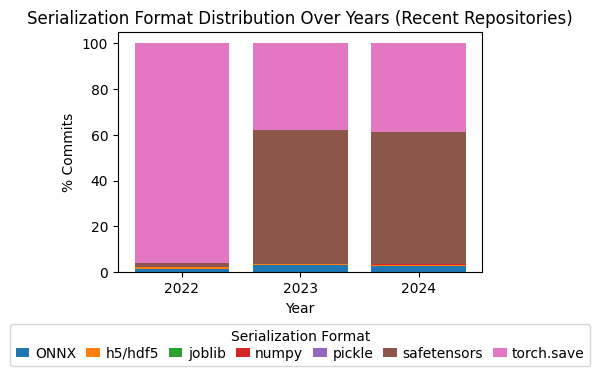

In [24]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt
import numpy as np

# Sample data
df = df[df['serialization_format'] != 'undetermined']
# Compute a slice of the DataFrame with the relevant columns
df_by_date = df[['year', 'serialization_format']]

# Group by year and serialization format, then count occurrences
grouped = df_by_date.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=fig_dimensions)  # Set the figure size based on the group under analysis

# Cumulative values for stacked bars
cumulative_values = np.zeros(len(grouped_percentage))

for serialization_format in grouped_percentage.columns:
    ax.bar(grouped_percentage.index, grouped_percentage[serialization_format],
           bottom=cumulative_values, label=serialization_format, color=color_map[serialization_format])
    cumulative_values += grouped_percentage[serialization_format]

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_xticks(year_range)  # Tick every year
ax.set_title(f'Serialization Format Distribution Over Years {title_suffix}')
# Move the legend outside  the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7,
          labelspacing=0.2,  # Reduce vertical space between labels
          handlelength=1.0,  # Shorter line handles
          handletextpad=0.4,  # Less space between handle and text
          borderaxespad=0.3,  # Padding between legend and axes
          borderpad=0.4,  # Padding inside the legend box
          columnspacing=0.7  # Horizontal space between columns (if used)
          )
# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# save as pdf
plt.savefig(RESULTS_DIR / f'RQ2FormatsStacked_{group_under_analysis}.pdf', format='pdf', bbox_inches='tight')
plt.show()



### Line Chart Repository-level breakdown:
We group by repo creation date buckets (e.g., month of repo creation) and compute the first format being used in the repo (we do so by grabbing first commit adding model files, whatever those might be) to see whether newer repos adopt it more quickly than older ones.

<Figure size 600x400 with 0 Axes>

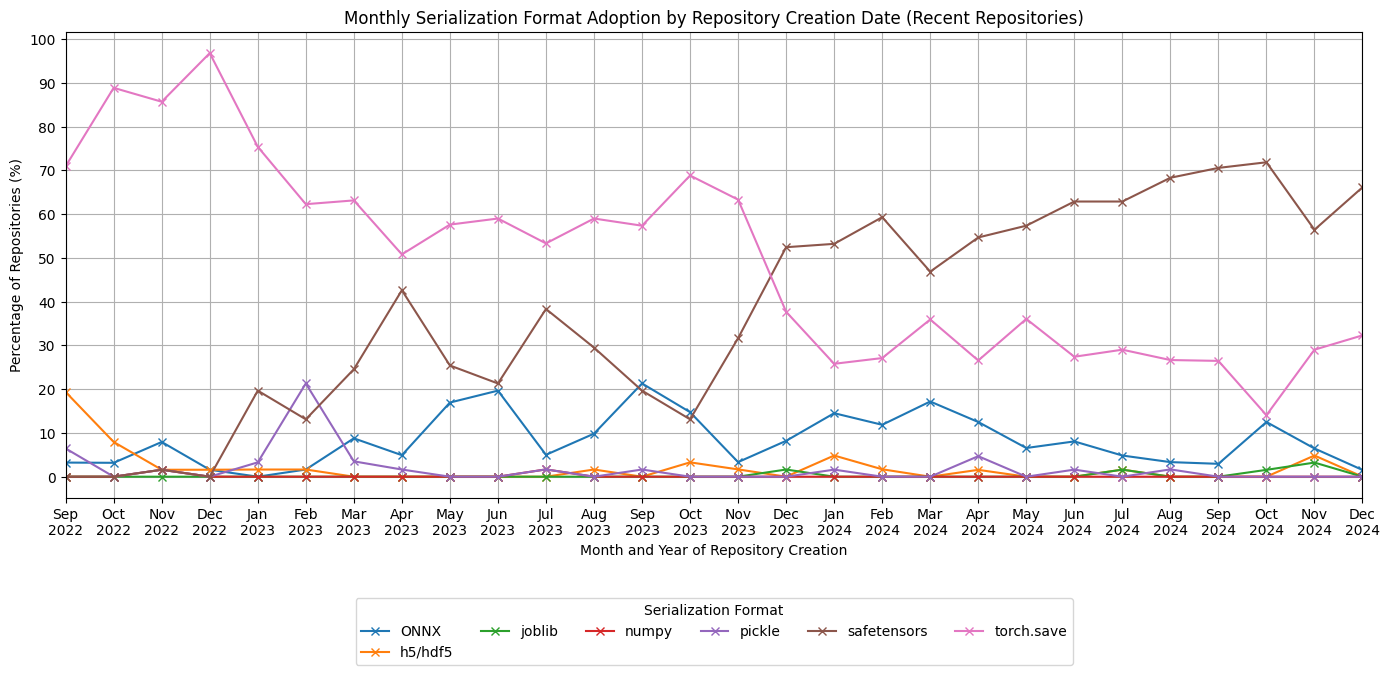

In [51]:
from nb_utils import extract_metadata

repos_metadata = extract_metadata(group_under_analysis)
df['created_at'] = df['repo_url'].map(lambda x: repos_metadata[x]['created_at'])
df['created_at_month_year'] = df['created_at'].dt.tz_localize(None).dt.to_period('M')
df_first_monthly_hash = df.sort_values('date').drop_duplicates(['repo_url', 'created_at'], keep='first')


# compute the counts of each serialization format per month of repo creation
serialization_format_counts = df_first_monthly_hash.groupby(['created_at_month_year', 'serialization_format']).size().unstack(fill_value=0)
# Plotting the distribution using a percentage line chart
serialization_format_counts = serialization_format_counts.div(serialization_format_counts.sum(axis=1), axis=0) * 100
# Set the figure size based on the group under analysis
fig_dimensions = (7, 4) if group_under_analysis != 'recent' else (6, 4)
title_suffix = f'({group_under_analysis.capitalize()} Repositories)' if group_under_analysis != 'both' else '(All Repositories)'
# Plotting the modified chart
import matplotlib.pyplot as plt
plt.figure(figsize=fig_dimensions)
ax = serialization_format_counts.plot(kind='line', marker='x', figsize=(14, 7))
plt.title(f'Monthly Serialization Format Adoption by Repository Creation Date {title_suffix}')
plt.xlabel('Month and Year of Repository Creation')
plt.ylabel('Percentage of Repositories (%)')
# plt.xticks(rotation=45)
# ensure the x-axis ticks are set to the month (fully qualified)
# month_names = serialization_format_counts.index.strftime('%Y-%b').tolist()
# print(month_names)
plt.xticks(serialization_format_counts.index, [m.strftime('%b\n%Y') for m in serialization_format_counts.index])

plt.yticks(np.arange(0, 101, 10))  # Set y-ticks from 0 to 100 with a step of 10
plt.grid(True)
# Move the legend outside the plot
plt.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)
plt.tight_layout()
# save as pdf
plt.savefig(RESULTS_DIR / f'RQ2FormatsRepoCreation_{group_under_analysis}.pdf', format='pdf', bbox_inches='tight')
plt.show()
